In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
# nltk.download() 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')
from textblob import TextBlob
from wordcloud import WordCloud

In [4]:
#load the data and prepare the dataset:
DATASET_COLUMNS=['label','ids','date','flag','user','tweet']
DATASET_ENCODING = "ISO-8859-1"
df_orgi = pd.read_csv('twitter.csv', encoding=DATASET_ENCODING, header=None, names=DATASET_COLUMNS)
df_orgi.sample(5)

np.sum(df_orgi.isnull().any(axis=1))#check missing value

df_orgi.label.value_counts() #800000 positive (label=4) & 800000 negative (label=0)
df_orgi.drop(['ids','date','flag','user'],axis=1,inplace=True) #drop the columns that not necessary
df_neg=df_orgi.iloc[0:100000] #first 100k rows are negative
df_pos=df_orgi.iloc[-100000:] #last 100k rows are positive

df=df_neg.append(df_pos,ignore_index = True) # concat two two dataframe
df.label.value_counts()
df['label'] = df['label'].replace(4,1)# Replacing the values to ease understanding. (Assigning 1 to Positive sentiment 4)
df.tail(10)


# add tweet text length column
df['pre_clean_len'] = [len(t) for t in df.tweet]


In [6]:
# =============================================================================
# # Data Dictionary — first draft
# from pprint import pprint
# data_dict = {
#     'label':{
#         'type':df.label.dtype,
#         'description':'label class - 0:negative, 1:positive'
#     },
#     'tweet':{
#         'type':df.tweet.dtype,
#         'description':'tweet text'
#     },
#     'pre_clean_len':{
#         'type':df.pre_clean_len.dtype,
#         'description':'Length of the tweet before cleaning'
#     },
#     'dataset_shape':df.shape
# }
# pprint(data_dict)
# =============================================================================

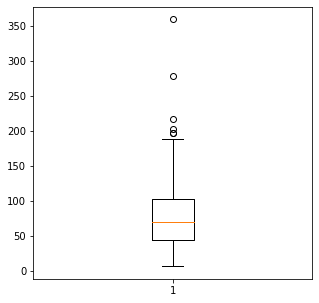

In [5]:
# box plot of string length
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.pre_clean_len)
plt.show()


In [7]:

# since twitter has characters limitation of 140, check why there are tweets more than 140 characters:
df[df.pre_clean_len > 140].head(10)


# =============================================================================
#  Cleaning Data:
# =============================================================================


# examples:
# =============================================================================
# # Making statement text in lower case:
# df['tweet']=df['tweet'].str.lower()
# df['tweet'].sample(10)
# 
# # HTML decoding
# df.tweet[279] #example shows there are some ‘&amp’,’&quot’,etc. 
# from bs4 import BeautifulSoup
# example1 = BeautifulSoup(df.tweet[279], 'lxml')
# print(example1.get_text())
# 
# # ‘@’mention
# df.tweet[343]
# re.sub(r'@[A-Za-z0-9]+','',df.tweet[343])
# 
# # URL links
# df.tweet[0]
# re.sub('https?://[A-Za-z0-9./]+','',df.tweet[0])
# 
# #UTF-8 BOM (Byte Order Mark)
# df.tweet[226]
# testing= re.sub("[^a-zA-Z]", " ",df.tweet[226]) #letters_only
# testing
# 
# #hashtag / numbers
# df.tweet[175]
# re.sub("[^a-zA-Z]", " ", df.tweet[175])
# 
# =============================================================================

,label,tweet,pre_clean_len
213,0,Awwh babs... you look so sad underneith that s...,142
226,0,Tuesdayï¿½ll start with reflection ï¿½n then a...,141
279,0,Whinging. My client&amp;boss don't understand ...,145
343,0,@TheLeagueSF Not Fun &amp; Furious? The new ma...,145
400,0,#3 woke up and was having an accident - &quot;...,144
464,0,"My bathtub drain is fired: it haz 1 job 2 do, ...",146
492,0,"pears &amp; Brie, bottle of Cabernet, and &quo...",150
747,0,Have an invite for &quot;Healthy Dining&quot; ...,141
957,0,Damnit I was really digging this season of Rea...,141
1064,0,Why do I keep looking...I know that what I rea...,141


In [8]:
# define data cleaning function:
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))
def tweet_cleaner(tweet):
    soup = BeautifulSoup(tweet, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

In [9]:
nums = [0,200000]
print ("Cleaning and parsing the tweets...\n")
clean_tweet_texts = []
for i in range(nums[0],nums[1]):
    if( (i+1)%10000 == 0 ):
        print ("Tweets %d of %d has been processed" % ( i+1, nums[1] ))
    clean_tweet_texts.append(tweet_cleaner(df['tweet'][i]))


clean_df = pd.DataFrame(clean_tweet_texts,columns=['tweet'])
clean_df['label'] = df.label
clean_df.head()

Cleaning and parsing the tweets...

Tweets 10000 of 200000 has been processed
Tweets 20000 of 200000 has been processed
Tweets 30000 of 200000 has been processed
Tweets 40000 of 200000 has been processed
Tweets 50000 of 200000 has been processed
Tweets 60000 of 200000 has been processed
Tweets 70000 of 200000 has been processed
Tweets 80000 of 200000 has been processed
Tweets 90000 of 200000 has been processed
Tweets 100000 of 200000 has been processed
Tweets 110000 of 200000 has been processed
Tweets 120000 of 200000 has been processed
Tweets 130000 of 200000 has been processed
Tweets 140000 of 200000 has been processed
Tweets 150000 of 200000 has been processed
Tweets 160000 of 200000 has been processed
Tweets 170000 of 200000 has been processed
Tweets 180000 of 200000 has been processed
Tweets 190000 of 200000 has been processed
Tweets 200000 of 200000 has been processed


,tweet,label
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


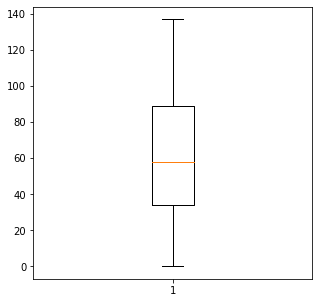

,tweet,label,pre_clean_len


In [10]:
# add tweet text length column
clean_df['pre_clean_len'] = [len(t) for t in clean_df.tweet]


# box plot of string length
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(clean_df.pre_clean_len)
plt.show()


# since twitter has characters limitation of 140, check why there are tweets more than 140 characters:
clean_df[clean_df.pre_clean_len > 140].head(10)
# empty, means there are no text more than 140 characters.

In [11]:
### Below doing more cleaning on the words level:

# Defining set containing all stopwords in English.To clear the Personal Pronoun.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves','day','today','got','going','time','im','think','one','think','know','twitter']

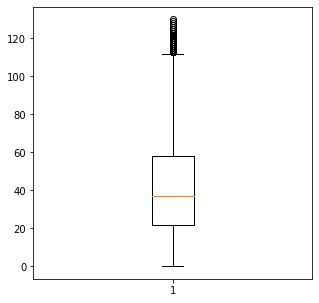

In [12]:
#Cleaning and removing the above stop words list from the tweet text
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
clean_df['tweet'] = clean_df['tweet'].apply(lambda text: cleaning_stopwords(text))
clean_df['tweet'].head()


#remove short words that less than 1 letter (I feel hmm and oh may be useful for the test, so I am going to keep them):
clean_df['tweet']=clean_df['tweet'].apply(lambda x:" ".join([w for w in x.split() if len(w)>1]))
    


clean_df['pre_clean_len'] = [len(t) for t in clean_df.tweet]

# box plot of string length
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(clean_df.pre_clean_len)
plt.show()

clean_df[clean_df.pre_clean_len > 140].head(10)
# now the length of each tweet is shorter

# Saving cleaned data as csv
clean_df.label.value_counts()
clean_df.to_csv('clean_tweet.csv',encoding='utf-8-sig')

In [13]:
## just make life easier, I rename clean_df as df:
    
df=pd.read_csv('clean_tweet.csv', header=None,encoding='utf-8-sig')
df = df.iloc[1: , 1:]
df.columns =['tweet','label','pre_clean_len']

df=df.applymap(str)###Above steps made the label 1 separately
np.sum(df.tweet=='nan') #check # of empty cells

# filter out the empty cells
df= df[df['tweet']!='nan']
df.label.value_counts()  
df = df.reset_index(drop=True)

# Do Tokenization again
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer("[\w']+")
df['tweet'] = df['tweet'].apply(tokenizer.tokenize)
df['tweet'].head()


0          [awww, bummer, shoulda, david, carr, third]
1    [upset, update, facebook, texting, might, cry,...
2    [dived, many, times, ball, managed, save, rest...
3              [whole, body, feels, itchy, like, fire]
4                  [no, not, behaving, mad, see, over]
Name: tweet, dtype: object

In [14]:

# Applying Stemming (to make all the format of words uniformed)

st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
df['tweet'] = df['tweet'].apply(lambda x: stemming_on_text(x))
df['tweet'].head()


#Applying Lemmatizer
from nltk.stem import WordNetLemmatizer 
    
    
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
df['tweet'] = df['tweet'].apply(lambda x: lemmatizer_on_text(x))
df['tweet'].head()


# combine words into single sentence:
for i in range(len(df.tweet)):
    df.tweet[i]=" ".join(df.tweet[i])
    
    

df['clean_len'] = [len(t) for t in df.tweet]

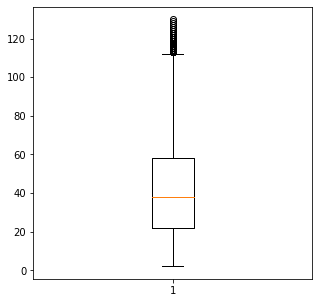

In [15]:
# box plot of string length
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.clean_len)
plt.show()

df[df.clean_len > 140].head(10)
# check the length of each tweet one last time
np.sum(len(df.pre_clean_len)!=len(df.clean_len)) #check how much improving
#0 as I have deleted the empty cells before, stemming and lemmatizer has no impact on length.

df=df.iloc[:,0:2] #Finish data cleaning



# saving as clean_tweet again:
df.to_csv('clean_tweet.csv', header=False,index=False)

In [16]:
## Reload the data as df for analysis: can directly load the data from the below line
    
df=pd.read_csv('clean_tweet.csv', header=None)
df.columns =['tweet','label']

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

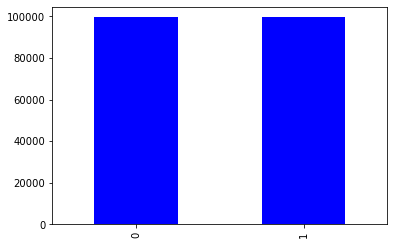

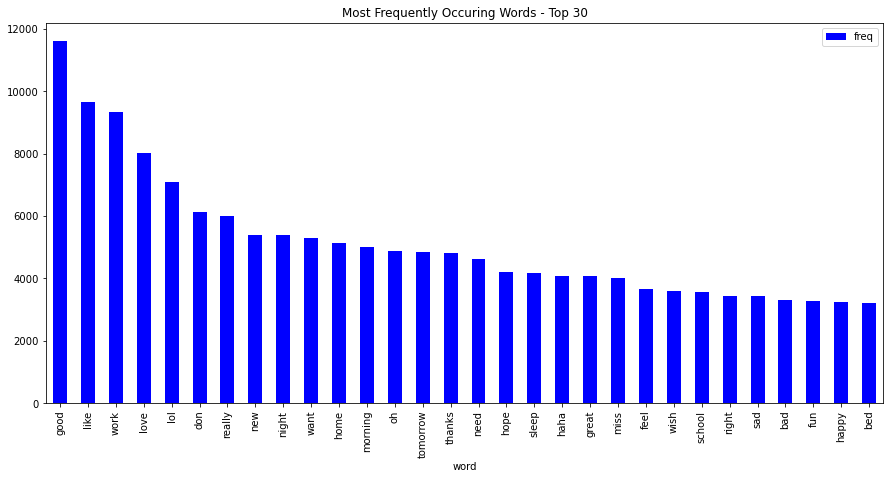

In [17]:
# =============================================================================
# Data Visulization
# =============================================================================
# Separating input features and label

df['label'].value_counts().plot.bar(color = 'Blue', figsize = (6, 4)) #positive and negative almost equal



### Check the frequency of words
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df.tweet)

sum_words = words.sum(axis=0)
# 77692 words totally 

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

Text(0.5, 1.0, 'WordCloud - all words')

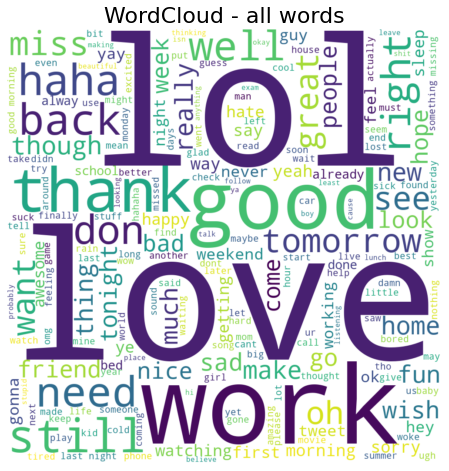

In [18]:
# Frequent words Visulization (all):
all_words=" ".join([sentence for sentence in df['tweet']])
wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000, random_state=42).generate(all_words)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud - all words", fontsize = 22)

Text(0.5, 1.0, 'WordCloud - negative words')

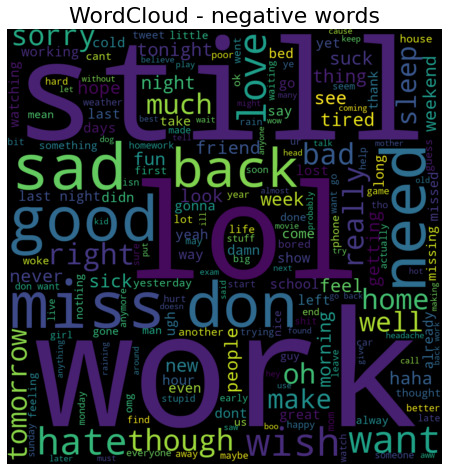

In [19]:
# Visualize the frequent words (negative):
neg_words=" ".join([sentence for sentence in df['tweet'][df['label']==0]])
wordcloud = WordCloud(width = 1000, height = 1000, random_state=42).generate(neg_words)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud - negative words", fontsize = 22)

Text(0.5, 1.0, 'WordCloud - positive words')

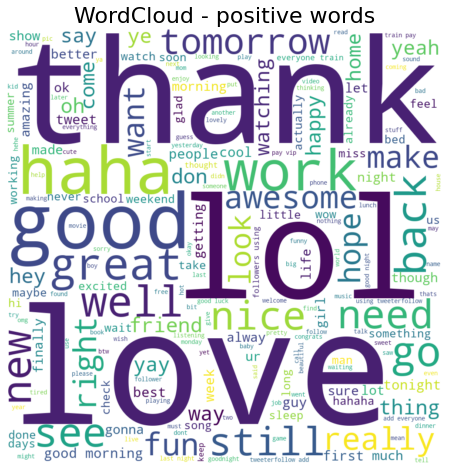

In [20]:
# Visualize the frequent words (positive):
pos_words=" ".join([sentence for sentence in df['tweet'][df['label']==1]])
wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000, random_state=42).generate(pos_words)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud - positive words", fontsize = 22)

In [36]:
# =============================================================================
# Feature Extraction using CountVectorizer， TfidfVectorizer to create bag of words:
# =============================================================================
X=df.tweet
y=df.label

# One-Hot text data representation: (frequency is 0 or 1)
cv = CountVectorizer(max_features = 2500,stop_words='english',binary=True)
X = cv.fit_transform(X)  


# Or
# CV:
cv = CountVectorizer(max_df=0.90, min_df=2, max_features = 2500,stop_words='english')
X = cv.fit_transform(X)
#X[0].toarray()
# min_df=2: ignore terms that appear in more than 90% of the documents
# max_df=0.90: only keep terms that appear in at least 2 documents



# Or
# TF-IDF:
tf= TfidfVectorizer(ngram_range=(1,2), max_features=2500)
X=tf.fit_transform(X)
# p=X[0].toarray()
# include 1-grams and 2-grams


In [37]:
# =============================================================================
# Appling Models
# =============================================================================
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5) #80% train,20% test

def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.77      0.76      0.76     19848
           1       0.76      0.77      0.77     19971

    accuracy                           0.77     39819
   macro avg       0.77      0.77      0.77     39819
weighted avg       0.77      0.77      0.77     39819

F1 score : 0.768725263236502
Accuracy rate  : 0.7666691780305884
[[15087  4761]
 [ 4530 15441]]
              precision    recall  f1-score   support

           0       0.77      0.76      0.76     19848
           1       0.76      0.77      0.77     19971

    accuracy                           0.77     39819
   macro avg       0.77      0.77      0.77     39819
weighted avg       0.77      0.77      0.77     39819

F1 score : 0.768725263236502
Accuracy rate  : 0.7666691780305884
[[15087  4761]
 [ 4530 15441]]
              precision    recall  f1-score   support

           0       0.75      0.78      0.76     19848
           1       0.77      0.74      0.76  

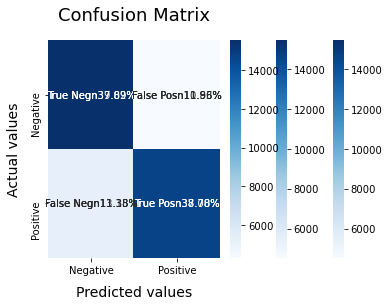

In [38]:

# =============================================================================
# Naive Bayes: I am using each of one-hot, cv, and tf-idf to do a BernoulliNB and MultinomialNB comparison as these two are most common in NLP:
# Although using multinomial for binary classification is strange, I still want to see the difference.
# =============================================================================
# Bernoulli NB using alpha=0:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(X_train, y_train)
model_Evaluate(clf)
y_pred=clf.predict(X_test)

print("F1 score :", f1_score(y_test, y_pred))
print("Accuracy rate  :", accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)


# Bernoulli NB using alpha=1: 
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB(alpha=1)
clf.fit(X_train, y_train)
model_Evaluate(clf)
y_pred=clf.predict(X_test)

print("F1 score :", f1_score(y_test, y_pred))
print("Accuracy rate  :", accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)


# Multinomial NB: 
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
model_Evaluate(clf)
y_pred=clf.predict(X_test)

print("F1 score :", f1_score(y_test, y_pred))
print("Accuracy rate  :", accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)

In [33]:
# Results:
# One-hot (frequency is 0 or 1):
# Bernoulli NB using alpha=0 accuracy rate=0.7553
# Bernoulli NB using alpha=1 accuracy rate=0.7553
# Multinomial NB accuracy rate=0.7501

# Cv:
# Bernoulli NB using alpha=0 accuracy rate=0.7550
# Bernoulli NB using alpha=1 accuracy rate=0.7550
# Multinomial NB accuracy rate=0.7490

# TFidf: 
# Bernoulli NB using alpha=0 accuracy rate=0.7667
# Bernoulli NB using alpha=1 accuracy rate=0.7667
# Multinomial NB accuracy rate=0.7602

# It seems TFidf works better for Multinomial NB. 
# One-hot and CV works better for Bernoulli NB than Multinomial NB which makes sense
# as most of the frequency in this dataset is 0 or 1.
# Multinomial NB works slightly better than Bernoulli NB by using Tfidf, but all in all
# Bernoulli NB works well.


In [39]:
# =============================================================================
# 
# =============================================================================

# CV is most common in NLP upon research, but since the best NB result from Tfidf, I will use Tfidf below.  (I also did CV, and the result is available in the script)


X=df.tweet
y=df.label


tf= TfidfVectorizer(ngram_range=(1,2), max_features=2500)
X=tf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5) #80% train,20% test


best parameters: {'n_neighbors': 1}


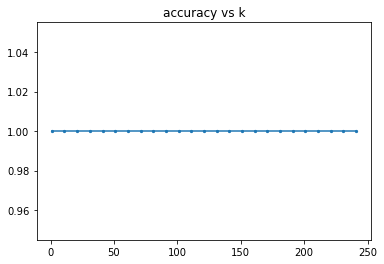

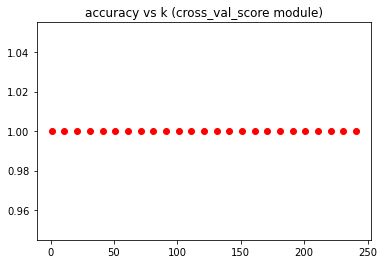

The best score is 1.0
when k= 1


In [41]:
# =============================================================================
# KNN
# =============================================================================
# Since the dataset is too large, I made a smaller set to see the pattern of the best K:
X=df.tweet[:5000]
y=df.label[:5000]
tf= TfidfVectorizer(ngram_range=(1,2), max_features=100)
X=tf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5) #80% train,20% test

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
knnClassifier = KNeighborsClassifier()

# Below is KNN algorithm with cross-validation.
# GridSearchCV method:
param_grid = {'n_neighbors': np.arange(1, 250,10)}
knn_gscv = GridSearchCV(knnClassifier, param_grid, return_train_score=True, cv=5)
knn_gscv.fit(X_train, y_train)

#check top performing n_neighbors value
print(f"best parameters: {knn_gscv.best_params_}")
plt.plot(param_grid['n_neighbors'],knn_gscv.cv_results_['mean_test_score'])
plt.scatter(param_grid['n_neighbors'],knn_gscv.cv_results_['mean_test_score'],s=5)
plt.title("accuracy vs k")
plt.show()

# Using cross_val_score module:
k_range=range(1,250,10)
k_score=[]
for k in k_range:
    knn_cv=KNeighborsClassifier(n_neighbors=k)
    scores =cross_val_score(knn_cv, X_train, y_train, cv=5, scoring='accuracy')
    k_score.append(scores.mean())
    
plt.plot(k_range,k_score, 'ro')
plt.title("accuracy vs k (cross_val_score module)")
plt.show()
max_k_score = max(k_score)
max_index_k = k_score. index(max(k_score))
print('The best score is' ,str(max_k_score ))
print('when k=',str(max_index_k+1))

              precision    recall  f1-score   support

           0       0.69      0.55      0.61     19848
           1       0.63      0.76      0.69     19971

    accuracy                           0.65     39819
   macro avg       0.66      0.65      0.65     39819
weighted avg       0.66      0.65      0.65     39819

The accuracy score is  0.6528039378186293
The confusion_matrix after prediction:
 [[10847  9001]
 [ 4824 15147]]


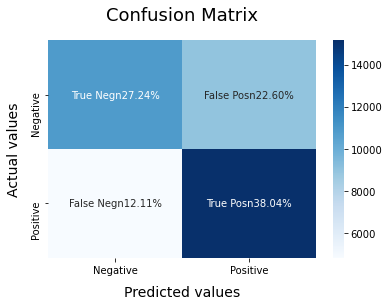

In [42]:
####################### It seems odd as all of the K has the same scores, so I am going to test some k: (the loop is very slow, so I m just picking some numbers)
X=df.tweet
y=df.label

tf= TfidfVectorizer(ngram_range=(1,2), max_features=2500)
X=tf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5) #80% train,20% test

# Predict with k=1
k=1
knnClassifier=KNeighborsClassifier(n_neighbors=k)
knnClassifier.fit(X_train,y_train)
model_Evaluate(knnClassifier)
y_pred=knnClassifier.predict(X_test)
print("The accuracy score is ", accuracy_score(y_test, y_pred))
print("The confusion_matrix after prediction:\n" ,confusion_matrix(y_test,y_pred))
# KNN with k=1 accuracy rate is TFidf 65.3%.  CV:61%

              precision    recall  f1-score   support

           0       0.72      0.51      0.60     19848
           1       0.62      0.80      0.70     19971

    accuracy                           0.66     39819
   macro avg       0.67      0.66      0.65     39819
weighted avg       0.67      0.66      0.65     39819

The accuracy score is  0.6587056430347321
The confusion_matrix after prediction:
 [[10207  9641]
 [ 3949 16022]]


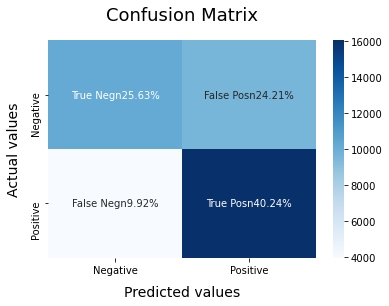

In [43]:
# Predict with k=3
k=3
knnClassifier=KNeighborsClassifier(n_neighbors=k)
knnClassifier.fit(X_train,y_train)
model_Evaluate(knnClassifier)
y_pred=knnClassifier.predict(X_test)
print("The accuracy score is ", accuracy_score(y_test, y_pred))
print("The confusion_matrix after prediction:\n" ,confusion_matrix(y_test,y_pred))
# KNN with k=3 accuracy rate is TFidf 65.87%. CV:67%


              precision    recall  f1-score   support

           0       0.72      0.50      0.59     19848
           1       0.62      0.81      0.70     19971

    accuracy                           0.66     39819
   macro avg       0.67      0.65      0.65     39819
weighted avg       0.67      0.66      0.65     39819

The accuracy score is  0.6553404153795926
The confusion_matrix after prediction:
 [[10009  9839]
 [ 3885 16086]]


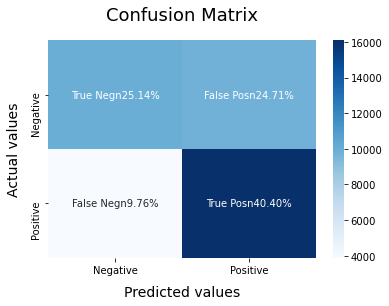

In [44]:
# Predict with k=20
k=20
knnClassifier=KNeighborsClassifier(n_neighbors=k)
knnClassifier.fit(X_train,y_train)
model_Evaluate(knnClassifier)
y_pred=knnClassifier.predict(X_test)
print("The accuracy score is ", accuracy_score(y_test, y_pred))
print("The confusion_matrix after prediction:\n" ,confusion_matrix(y_test,y_pred))
# KNN with k=20 accuracy rate TFidf is 65.53%. CV:69%

In [ ]:
# Try more k:
# KNN with k=100 accuracy rate is TFidf 60.0%. CV:67%
# KNN with k=150 accuracy rate is TFidf 58.0%. CV:66%. So I guess the best k is between 20-100 by CV.
# KNN with k=60 accuracy rate is TFidf 62.29%. CV: 66%. Try a k between 20-60
# KNN with k=40 accuracy rate is TFidf 63.79% CV: 68%.
# KNN with k=30 accuracy rate is TFidf 64.68% CV: 68%.
# So far, the best k is 20 and the accuracy rate is 69% with CV. 
# Since the dataset is very large, and the accuracy of knn given k=20 is lower than Naive Bayes method, it seems knn is not a good method for this analysis.


              precision    recall  f1-score   support

           0       0.53      0.95      0.68     19848
           1       0.75      0.16      0.27     19971

    accuracy                           0.55     39819
   macro avg       0.64      0.55      0.47     39819
weighted avg       0.64      0.55      0.47     39819

Number of mislabeled points out of a total 39819 points : 17817
The confusion matrix:
 [[18778  1070]
 [16747  3224]]
The accuracy score is  0.552550290062533
Error rate: 0.447


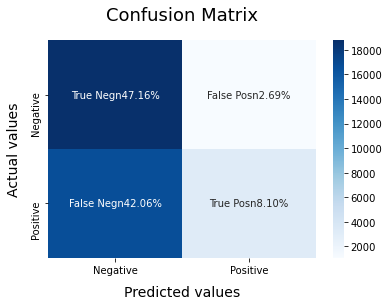

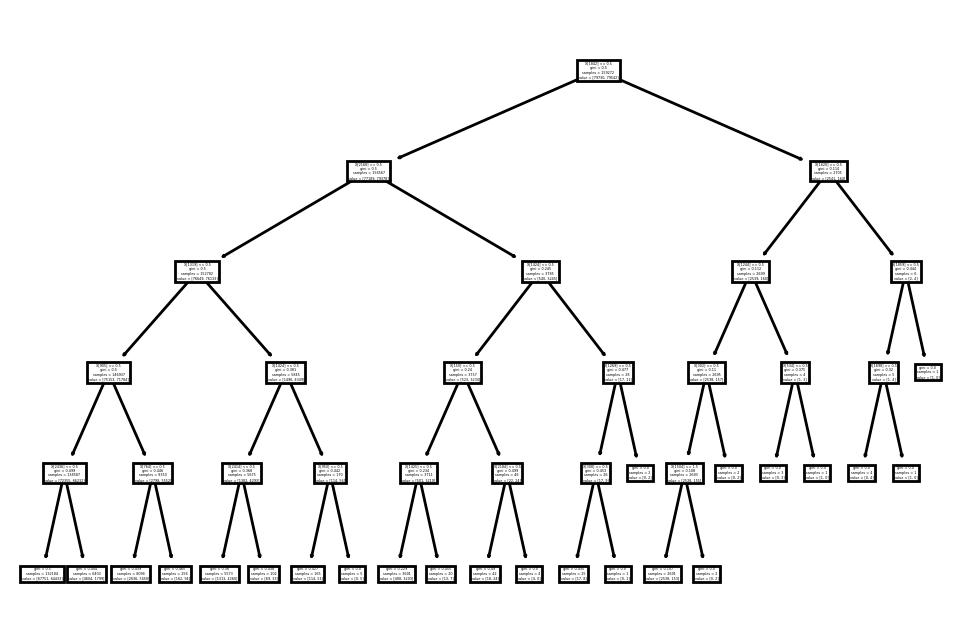

              precision    recall  f1-score   support

           0       0.81      0.18      0.29     19848
           1       0.54      0.96      0.69     19971

    accuracy                           0.57     39819
   macro avg       0.67      0.57      0.49     39819
weighted avg       0.67      0.57      0.49     39819

Number of mislabeled points out of a total 39819 points : 17161
The confusion matrix:
 [[ 3533 16315]
 [  846 19125]]
The accuracy score is  0.5690248373891861
Error rate: 0.431


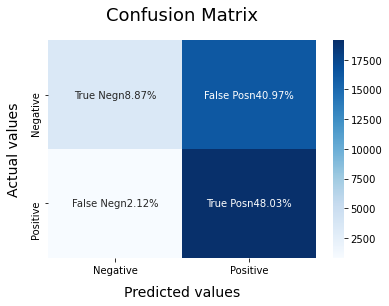

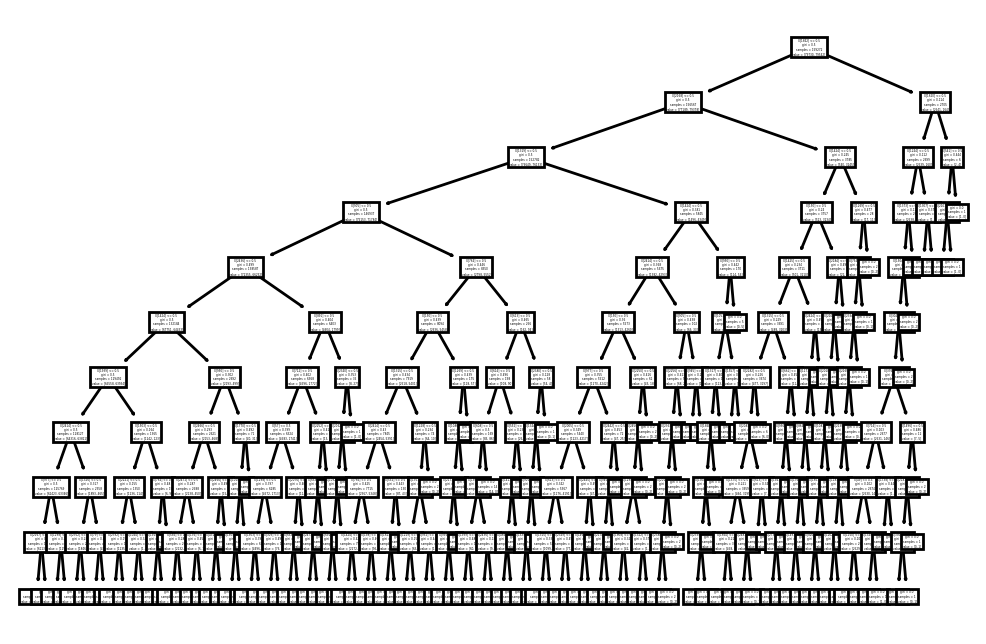

              precision    recall  f1-score   support

           0       0.72      0.40      0.52     19848
           1       0.59      0.84      0.69     19971

    accuracy                           0.62     39819
   macro avg       0.65      0.62      0.60     39819
weighted avg       0.65      0.62      0.60     39819

Number of mislabeled points out of a total 39819 points : 14981
The confusion matrix:
 [[ 7999 11849]
 [ 3132 16839]]
The accuracy score is  0.6237725708832467
Error rate: 0.376


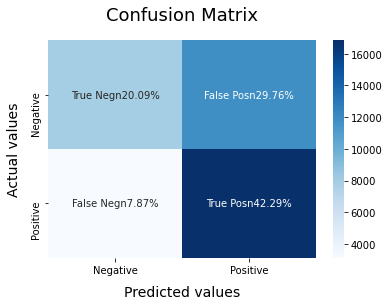

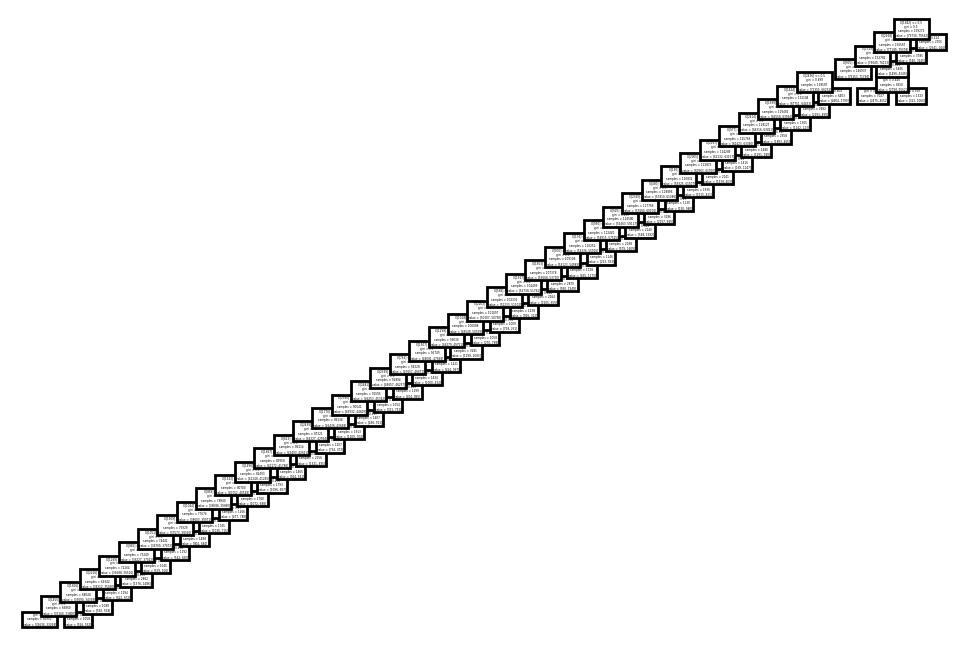

              precision    recall  f1-score   support

           0       0.68      0.36      0.47     19848
           1       0.57      0.83      0.67     19971

    accuracy                           0.60     39819
   macro avg       0.62      0.60      0.57     39819
weighted avg       0.62      0.60      0.57     39819

Number of mislabeled points out of a total 39819 points : 16055
The confusion matrix:
 [[ 7102 12746]
 [ 3309 16662]]
The accuracy score is  0.5968005223636957
Error rate: 0.403
              precision    recall  f1-score   support

           0       0.73      0.50      0.59     19848
           1       0.62      0.81      0.70     19971

    accuracy                           0.66     39819
   macro avg       0.67      0.66      0.65     39819
weighted avg       0.67      0.66      0.65     39819

Number of mislabeled points out of a total 39819 points : 13639
The confusion matrix:
 [[ 9952  9896]
 [ 3743 16228]]
The accuracy score is  0.6574750747130766
Error ra

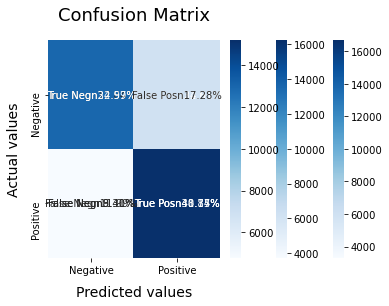

In [45]:

# =============================================================================
# CART
# =============================================================================
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

X=df.tweet
y=df.label

# =============================================================================
# tf= TfidfVectorizer(ngram_range=(1,2), max_features=2500)
# X=tf.fit_transform(X)
# =============================================================================

cv = CountVectorizer(max_df=0.90, min_df=2, max_features = 2500,stop_words='english')
X = cv.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)



# Max depth=5
tree=DecisionTreeClassifier(max_depth=5)
treeModel=tree.fit(X_train, y_train)
model_Evaluate(treeModel)
y_pred=treeModel.predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
C=confusion_matrix(y_test, y_pred)
print("The confusion matrix:\n", C)
print("The accuracy score is ", accuracy_score(y_test, y_pred))
print(f"Error rate: {(1.-sum(np.diag(C))/C.sum()):5.3}")

fig=plt.figure(dpi=200)
sub=fig.add_subplot(1,1,1)
plot_tree(treeModel)
plt.show()


# Max depth=10
tree=DecisionTreeClassifier(max_depth=10)
treeModel=tree.fit(X_train, y_train)
model_Evaluate(treeModel)
y_pred=treeModel.predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
C=confusion_matrix(y_test, y_pred)
print("The confusion matrix:\n", C)
print("The accuracy score is ", accuracy_score(y_test, y_pred))
print(f"Error rate: {(1.-sum(np.diag(C))/C.sum()):5.3}")

fig=plt.figure(dpi=200)
sub=fig.add_subplot(1,1,1)
plot_tree(treeModel)
plt.show()


# Minimum number of points per leave= 1000
tree=DecisionTreeClassifier(min_samples_leaf=1000)
treeModel=tree.fit(X_train, y_train)
model_Evaluate(treeModel)
y_pred=treeModel.predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
C=confusion_matrix(y_test, y_pred)
print("The confusion matrix:\n", C)
print("The accuracy score is ", accuracy_score(y_test, y_pred))
print(f"Error rate: {(1.-sum(np.diag(C))/C.sum()):5.3}")

fig=plt.figure(dpi=200)
sub=fig.add_subplot(1,1,1)
plot_tree(treeModel)
plt.show()


# Minimum number of points per leave= 2000
tree=DecisionTreeClassifier(min_samples_leaf=2000)
treeModel=tree.fit(X_train, y_train)
model_Evaluate(treeModel)
y_pred=treeModel.predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
C=confusion_matrix(y_test, y_pred)
print("The confusion matrix:\n", C)
print("The accuracy score is ", accuracy_score(y_test, y_pred))
print(f"Error rate: {(1.-sum(np.diag(C))/C.sum()):5.3}")


# Minimum number of points per leave= 500
tree=DecisionTreeClassifier(min_samples_leaf=500)
treeModel=tree.fit(X_train, y_train)
model_Evaluate(treeModel)
y_pred=treeModel.predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
C=confusion_matrix(y_test, y_pred)
print("The confusion matrix:\n", C)
print("The accuracy score is ", accuracy_score(y_test, y_pred))
print(f"Error rate: {(1.-sum(np.diag(C))/C.sum()):5.3}")

# Minimum number of points per leave= 100
tree=DecisionTreeClassifier(min_samples_leaf=100)
treeModel=tree.fit(X_train, y_train)
model_Evaluate(treeModel)
y_pred=treeModel.predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
C=confusion_matrix(y_test, y_pred)
print("The confusion matrix:\n", C)
print("The accuracy score is ", accuracy_score(y_test, y_pred))
print(f"Error rate: {(1.-sum(np.diag(C))/C.sum()):5.3}")

# result
# I found changing minimum number of points per leave can improve model (below is using CV method):

# The accuracy of Max depth=5 tree is 55%.
# The accuracy of Max depth=10 tree is 57%.
# The accuracy of Minimum number of points per leave= 1000 tree is 62%.
# The accuracy of Minimum number of points per leave= 2000 tree is 60%.
# The accuracy of Minimum number of points per leave= 500 tree is 65%.
# The accuracy of Minimum number of points per leave= 100 tree is 70%.
# ... Please see below graph

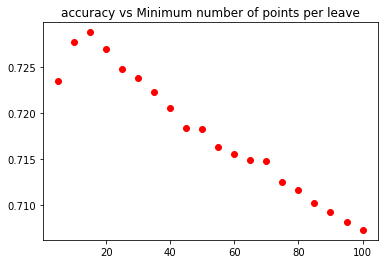

The best score is 0.7287475828122253
when i= 15


In [46]:


i_range=range(5,101,5)
loa=[]
for i in i_range:
    tree=DecisionTreeClassifier(min_samples_leaf=i)
    treeModel=tree.fit(X_train, y_train)
    y_pred=treeModel.predict(X_test)
    loa.append(accuracy_score(y_test, y_pred))
    
 
plt.plot(i_range,loa, 'ro')
plt.title("accuracy vs Minimum number of points per leave")
plt.show()

    
max_i_score = max(loa)
max_index_i = loa.index(max(loa))
print('The best score is' ,str(max_i_score ))
print('when i=',str((max_index_i+1)*5))    


              precision    recall  f1-score   support

           0       0.73      0.72      0.73     19848
           1       0.73      0.74      0.73     19971

    accuracy                           0.73     39819
   macro avg       0.73      0.73      0.73     39819
weighted avg       0.73      0.73      0.73     39819

Number of mislabeled points out of a total 39819 points : 10812
The confusion matrix:
 [[14293  5555]
 [ 5257 14714]]
The accuracy score is  0.7284713327808333
Error rate: 0.272


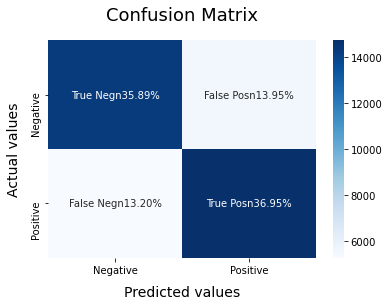

In [47]:
# Best Tree: Minimum number of points per leave= 15
tree=DecisionTreeClassifier(min_samples_leaf=15)
treeModel=tree.fit(X_train, y_train)
model_Evaluate(treeModel)
y_pred=treeModel.predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
C=confusion_matrix(y_test, y_pred)
print("The confusion matrix:\n", C)
print("The accuracy score is ", accuracy_score(y_test, y_pred))
print(f"Error rate: {(1.-sum(np.diag(C))/C.sum()):5.3}")

# The best tree model is when the Minimum number of points per leave= 15, the accuracy rate is around 72.87% with CV.

#The best tree of TF-idf is when i=35, score=0.7218

              precision    recall  f1-score   support

           0       0.75      0.71      0.73     19848
           1       0.72      0.76      0.74     19971

    accuracy                           0.73     39819
   macro avg       0.74      0.73      0.73     39819
weighted avg       0.74      0.73      0.73     39819

[[14004  5844]
 [ 4729 15242]]
Test Accuracy for the RandomForestClassifier model: 0.734473492553806
Test error for the RandomForestClassifier model: 0.266
The Out-of- bag score: 0.7331922748505701
Oob score is very close to the test accuracy.


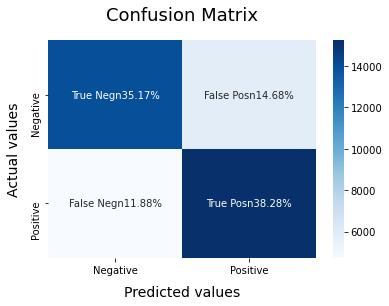

In [48]:
# =============================================================================
# Random Forest
# =============================================================================

X=df.tweet
y=df.label

# =============================================================================
# tf= TfidfVectorizer(ngram_range=(1,2), max_features=2500)
# X=tf.fit_transform(X)
# =============================================================================

cv = CountVectorizer(max_df=0.90, min_df=2, max_features = 2500,stop_words='english')
X = cv.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)




from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=500,min_samples_leaf=20,n_jobs=-1,oob_score=True)
rfModel=rf.fit(X_train,y_train)
model_Evaluate(rfModel)
y_pred=rfModel.predict(X_test)
C=confusion_matrix(y_test,y_pred)
print(C)
print(f"Test Accuracy for the RandomForestClassifier model: {accuracy_score(y_test, y_pred)}")
print(f"Test error for the RandomForestClassifier model: {1-accuracy_score(y_test, y_pred):5.3}")
print(f"The Out-of- bag score: {rfModel.oob_score_}")
print('Oob score is very close to the test accuracy.')

#The random forest given number of estima-
# tors 500, and with minimum number items per leaf equal to 20 has an accuracy around 73.4% (CV). 74.88% (TF-idf)


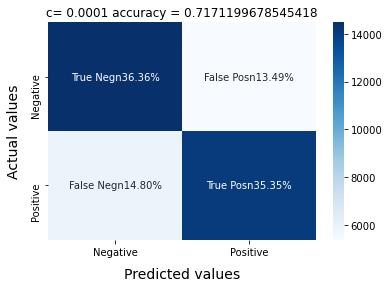

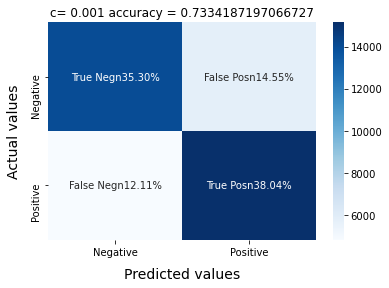

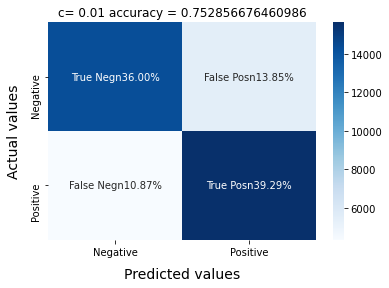

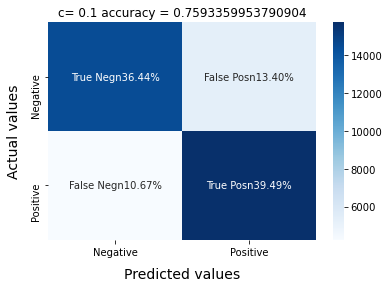

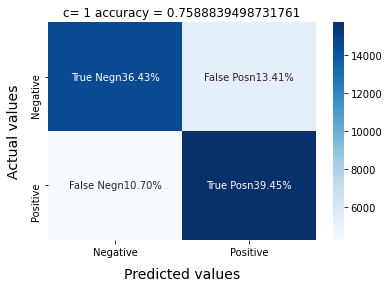

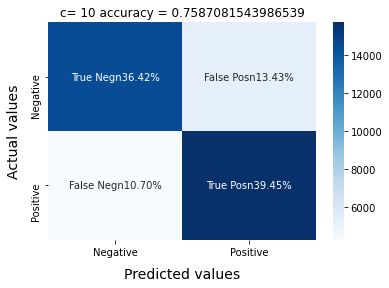

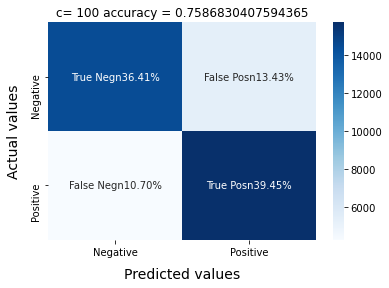

The accuracy rate of each c is[0.7171199678545418, 0.7334187197066727, 0.752856676460986, 0.7593359953790904, 0.7588839498731761, 0.7587081543986539, 0.7586830407594365]
The highest accuracy is 0.7593359953790904 when c= 0.1 .



In [49]:
# =============================================================================
# Logistic Regression
# =============================================================================
X=df.tweet
y=df.label

cv = CountVectorizer(max_df=0.90, min_df=2, max_features = 2500,stop_words='english')
X = cv.fit_transform(X)

# =============================================================================
# tf= TfidfVectorizer(ngram_range=(1,2), max_features=2500)
# X=tf.fit_transform(X)
# =============================================================================

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)

from sklearn.linear_model import LogisticRegression

# Logistic regression with simple linear separators
# L2 regularization with the SAG optimization method: note that c is the inverse of lamda as described in the documentation. So, the larger c is the less regularization, that is, the smaller the corresponding lamda; and the smaller it is the larger the regularization.)
c = [0.0001,0.001,0.01,0.1,1,10,100]
l=[]
for i in c:    
    log_rig=LogisticRegression(random_state=0,solver='sag',multi_class='multinomial',penalty='l2',C=i, max_iter = 1000, n_jobs=-1)
    log_rig.fit(X_train, y_train)
    y_pred=log_rig.predict(X_test)    
    C=confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in C.flatten() / np.sum(C)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(C, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    acc = accuracy_score(y_pred,y_test)
    plt.title(f"c= {i} accuracy = {acc}")
    plt.show()
    l.append(acc)


maxl=max(l)
maxindex=l.index(maxl)
print('The accuracy rate of each c is'+str(l))
print('The highest accuracy is', str(maxl), 'when c=', str(c[maxindex]),'.\n')
# CV result:
# The accuracy rate of each c is[0.7171199678545418, 0.7334187197066727, 0.752856676460986, 0.7593359953790904, 0.7588839498731761, 0.7587081543986539, 0.7586830407594365]
# The highest accuracy is 0.7593359953790904 when c= 0.1 .


#TF-idf: 
#The accuracy rate of each c is[0.7385419021070343, 0.7413044024209549, #0.7614706547125744, 0.7771666792234863, 0.7781209975137497, 0.7769406564705291, #0.776764860996007]
#The highest accuracy is 0.7781209975137497 when c= 1 .

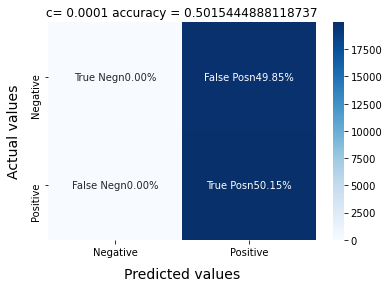

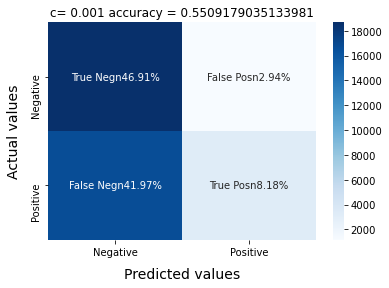

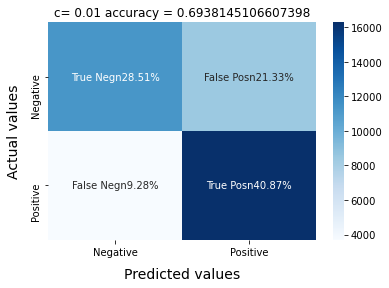

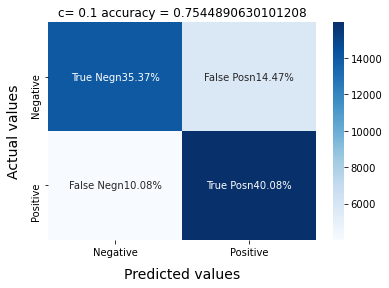

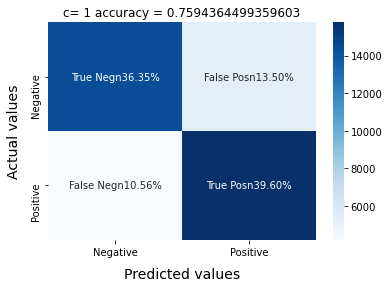

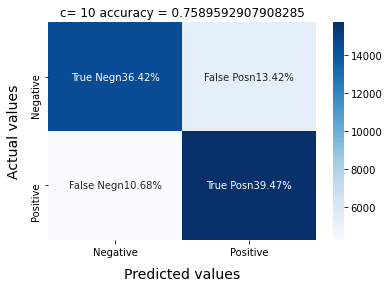

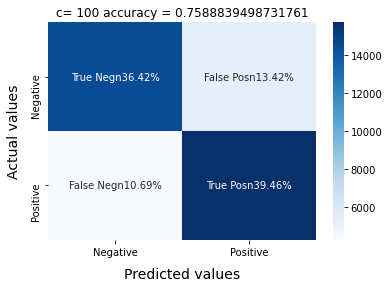

The accuracy rate of each c is[0.5015444888118737, 0.5509179035133981, 0.6938145106607398, 0.7544890630101208, 0.7594364499359603, 0.7589592907908285, 0.7588839498731761]
The highest accuracy is 0.7594364499359603 when c= 1 .



In [50]:
# l1 lasso regularization with SAGA optimization method.
c = [0.0001,0.001,0.01,0.1,1,10,100]
l=[]
for i in c:    
    log_rig=LogisticRegression(random_state=0,solver='saga',multi_class='multinomial',penalty='l1',C=i)
    log_rig.fit(X_train, y_train)
    y_pred=log_rig.predict(X_test)    
    C=confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in C.flatten() / np.sum(C)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(C, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    acc = accuracy_score(y_pred,y_test)
    plt.title(f"c= {i} accuracy = {acc}")
    plt.show()
    l.append(acc)
maxl=max(l)
maxindex=l.index(maxl)
print('The accuracy rate of each c is'+str(l))
print('The highest accuracy is', str(maxl), 'when c=', str(c[maxindex]),'.\n')
# CV result:
# The accuracy rate of each c is[0.5015444888118737, 0.5509179035133981, 0.6938145106607398, 0.7544890630101208, 0.7594364499359603, 0.7589592907908285, 0.7588839498731761]
# The highest accuracy is 0.7594364499359603 when c= 1 .

#TF-idf: 
#The accuracy rate of each c is[0.49845551118812625, 0.5015444888118737, #0.6807303046284437, 0.764785655089279, 0.7785228157412291, 0.7769908837489641, #0.7766644064391371]
#The highest accuracy is 0.7785228157412291 when c= 1 .
    
    

In [51]:
# =============================================================================
# from sklearn.preprocessing import PolynomialFeatures
# # Polynomial logistic regression model:
# while True:
#     d=int(input("Enter the degree of polynomial (0 to quit):"))
#     if d==0 or not isinstance(d,int):
#         break
#     poly = PolynomialFeatures(degree = d,  interaction_only=False, include_bias=True)
#     X_test_poly=poly.fit_transform(X_test)
#     X_train_poly=poly.fit_transform(X_train)
#     
#     poly_model=LogisticRegression(max_iter=1000)
#     poly_model.fit(X_train_poly,y_train)
#     y_train_poly_pred=poly_model.predict(X_train_poly)
#     y_test_poly_pred=poly_model.predict(X_test_poly)
#     C_poly_train=confusion_matrix(y_train,y_train_poly_pred)
#     C_poly_test=confusion_matrix(y_test,y_test_poly_pred)
#     print(f"Training accuracy_score for the polynomial({d}) model: {accuracy_score(y_train, y_train_poly_pred):4.3f}")
#     print(f"Test accuracy_score for the polynomial({d}) model: {accuracy_score(y_test,y_test_poly_pred):4.3f}")
#     print(f"Training Confusion Matrix for Polynomial degree {d}:")
#     print(C_poly_train)
#     print(f"Train accuracy for Polynomial model degree {d}: {np.sum(np.diag(C_poly_train))/np.sum(C_poly_train)}")
#     print(classification_report(y_train, y_train_poly_pred))
#     print("Test Test Confusion Matrix for the polynomial model:")
#     print(C_poly_test)
#     print(f"Test accuracy for polynomial model degree {d}: {np.sum(np.diag(C_poly_test))/np.sum(C_poly_test)}")
#     print(classification_report(y_test, y_test_poly_pred))
# =============================================================================
# When d = 2, Train accuracy for Polynomial model degree 2: 0.9326433320787856.
# Test accuracy for polynomial model degree 2: 0.759559413890004






In [52]:
# =============================================================================
# It takes too long, so I tried PCA (or TruncatedSVD , PCA-like dimmensionality reduction algorithm ,but for sparse input x) to do feature selection: 
# =============================================================================
X=df.tweet
y=df.label

cv = CountVectorizer(max_df=0.90, min_df=2, max_features = 2500,stop_words='english')
X = cv.fit_transform(X)

# =============================================================================
# tf= TfidfVectorizer(ngram_range=(1,2), max_features=2500)
# X=tf.fit_transform(X)
# =============================================================================

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)


from sklearn.decomposition import TruncatedSVD,PCA
x=X.toarray() # or use TruncatedSVD for sparse input x
r=0.8# 2500 to 875 features with CV, to 1151 features with TF-idf
pca1=PCA(n_components=r)
X_pca=pca1.fit_transform(x) 

X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca,y,test_size=0.2,random_state=5)


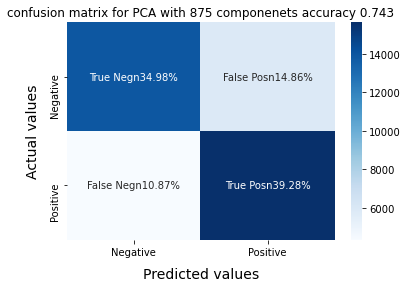

In [53]:
# PCA test 
log_rig_pca=LogisticRegression(max_iter=1000)
log_rig_pca.fit(X_train_pca, y_train)
y_pred_pca=log_rig_pca.predict(X_test_pca)
C_pca=confusion_matrix(y_test, y_pred_pca)
categories = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in C_pca.flatten() / np.sum(C_pca)]
labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(C_pca, annot = labels, cmap = 'Blues',fmt = '',
xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title(f"confusion matrix for PCA with {X_pca.shape[1]} componenets accuracy {sum(np.diag(C_pca))/C_pca.sum():5.3}")
plt.show()
#PCA with 875 componenents accuracy is 0.743.

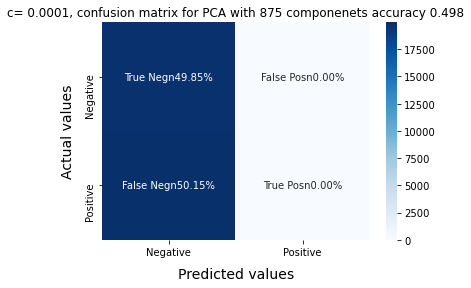

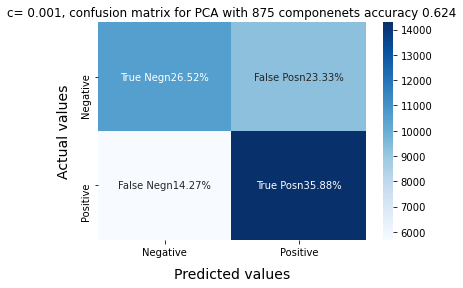

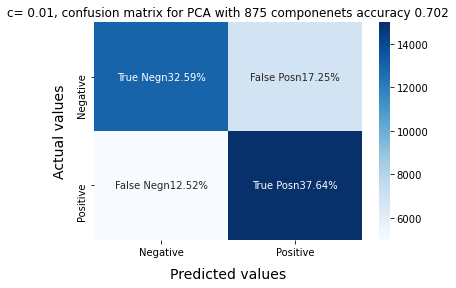

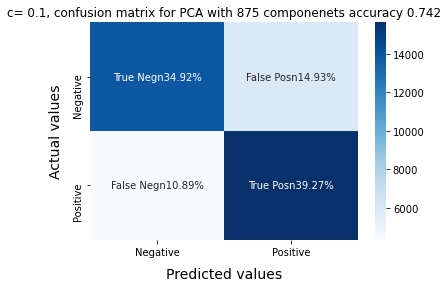

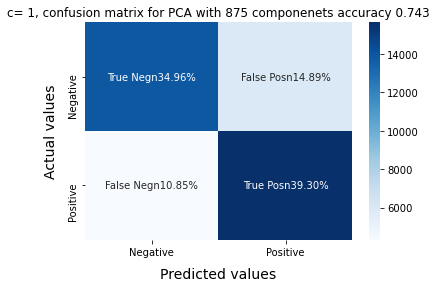

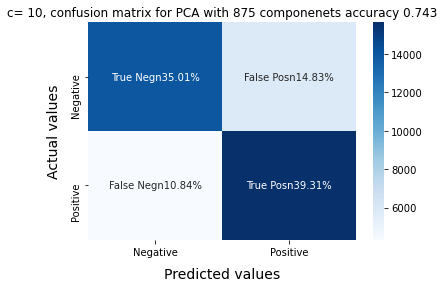

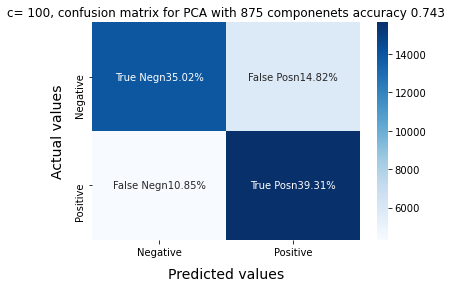

The accuracy rate of each c is[0.49845551118812625, 0.6239985936362038, 0.7022778070770236, 0.741806675205304, 0.7425851980210453, 0.7432381526406991, 0.7432632662799166]
The highest accuracy is 0.7432632662799166 when c= 100 .



In [54]:
# PCA l1 lasso regularization with SAGA optimization method.
c = [0.0001,0.001,0.01,0.1,1,10,100]
l=[]
for i in c:    
    log_rig_pca=LogisticRegression(random_state=0,solver='saga',multi_class='multinomial',penalty='l1',C=i)
    log_rig_pca.fit(X_train_pca, y_train)
    y_pred_pca=log_rig_pca.predict(X_test_pca)
    C_pca=confusion_matrix(y_test, y_pred_pca)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in C_pca.flatten() / np.sum(C_pca)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(C_pca, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title(f"c= {i}, confusion matrix for PCA with {X_pca.shape[1]} componenets accuracy {sum(np.diag(C_pca))/C_pca.sum():5.3}")
    plt.show()
    acc = accuracy_score(y_pred_pca,y_test)
    l.append(acc)
maxl=max(l)
maxindex=l.index(maxl)
print('The accuracy rate of each c is'+str(l))
print('The highest accuracy is', str(maxl), 'when c=', str(c[maxindex]),'.\n')

#CV result: 875 features
#The accuracy rate of each c is[0.49845551118812625, 0.6239985936362038, 0.7022778070770236, 0.741806675205304, 0.7425851980210453, 0.7432381526406991, 0.7432632662799166]
#The highest accuracy is 0.7432632662799166 when c= 100 .


#TF-idf result: 1151 features
#The accuracy rate of each c is[0.49845551118812625, 0.634621663025189, #0.7024787161907632, 0.7574524724377809, 0.7664682689168487, 0.766644064391371, #0.7662171325246742]
#The highest accuracy is 0.766644064391371 when c= 10 .

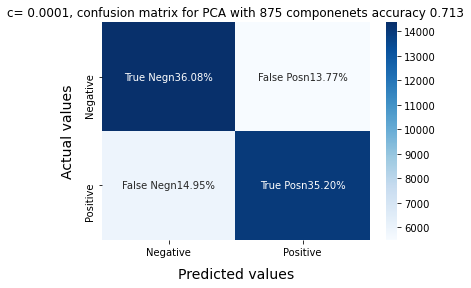

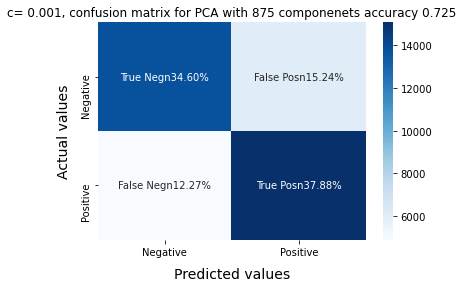

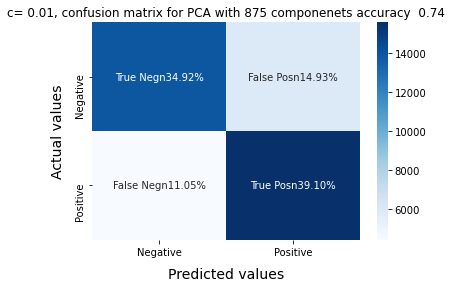

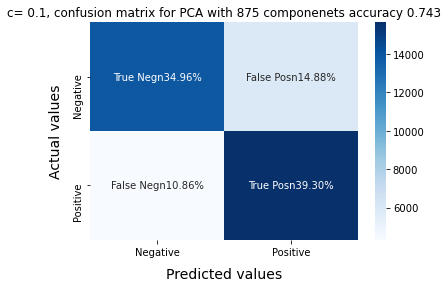

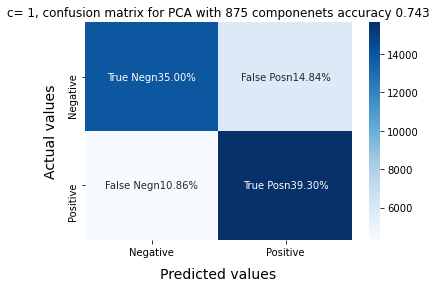

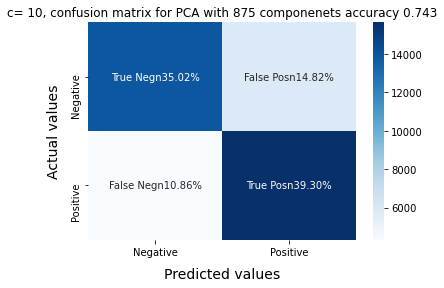

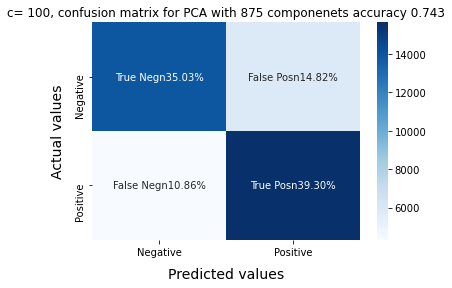

The accuracy rate of each c is[0.7128004219091388, 0.7248549687335192, 0.740224515934604, 0.7425600843818277, 0.7429870162485246, 0.7431879253622643, 0.7432130390014817]
The highest accuracy is 0.7432130390014817 when c= 100 .



In [55]:
# PCA L2 regularization with the SAG optimization method: 
c = [0.0001,0.001,0.01,0.1,1,10,100]
l=[]
for i in c:    
    log_rig_pca=LogisticRegression(random_state=0,solver='sag',multi_class='multinomial',penalty='l2',C=i, max_iter = 1000, n_jobs=-1)
    log_rig_pca.fit(X_train_pca, y_train)
    y_pred_pca=log_rig_pca.predict(X_test_pca)
    C_pca=confusion_matrix(y_test, y_pred_pca)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in C_pca.flatten() / np.sum(C_pca)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(C_pca, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title(f"c= {i}, confusion matrix for PCA with {X_pca.shape[1]} componenets accuracy {sum(np.diag(C_pca))/C_pca.sum():5.3}")
    plt.show()
    acc = accuracy_score(y_pred_pca,y_test)
    l.append(acc)
maxl=max(l)
maxindex=l.index(maxl)
print('The accuracy rate of each c is'+str(l))
print('The highest accuracy is', str(maxl), 'when c=', str(c[maxindex]),'.\n')

# CV result: 875 features
# The accuracy rate of each c is[0.7128004219091388, 0.7248549687335192, 0.740224515934604, 0.7425600843818277, 0.7429870162485246, 0.7431879253622643, 0.7432130390014817]
# The highest accuracy is 0.7432130390014817 when c= 100 .


#TF-idf result: 1151 features
#The accuracy rate of each c is[0.7351013335342425, 0.7386172430246867, 0.7563223586729954, 0.7649112232853663, 0.7662673598031091, 0.7663929279991963, 0.7498179261156734]
#The highest accuracy is 0.7663929279991963 when c= 10 .

In [ ]:
# I tried to apply PCA component=200 to poly LR, but when d=5 there is an error: MemoryError: Unable to allocate 833. TiB for an array with shape (39856, 2872408791) and data type float64. PCA may not be good for this NLP project as the cost is too high. I will try SVM or NN later.
# =============================================================================
# while True:
#     d=int(input("Enter the degree of polynomial (0 to quit):"))
#     if d==0 or not isinstance(d,int):
#         break
#     poly = PolynomialFeatures(degree = d,  interaction_only=False, include_bias=True)
#     X_test_poly=poly.fit_transform(X_test_pca)
#     X_train_poly=poly.fit_transform(X_train_pca)
#     
#     poly_model=LogisticRegression(max_iter=1000)
#     poly_model.fit(X_train_poly,y_train)
#     y_train_poly_pred=poly_model.predict(X_train_poly)
#     y_test_poly_pred=poly_model.predict(X_test_poly)
#     C_poly_train=confusion_matrix(y_train,y_train_poly_pred)
#     C_poly_test=confusion_matrix(y_test,y_test_poly_pred)
#     print(f"Training accuracy_score for the polynomial({d}) model: {accuracy_score(y_train, y_train_poly_pred):4.3f}")
#     print(f"Test accuracy_score for the polynomial({d}) model: {accuracy_score(y_test,y_test_poly_pred):4.3f}")
#     print(f"Training Confusion Matrix for Polynomial degree {d}:")
#     print(C_poly_train)
#     print(f"Train accuracy for Polynomial model degree {d}: {np.sum(np.diag(C_poly_train))/np.sum(C_poly_train)}")
#     print(classification_report(y_train, y_train_poly_pred))
#     print("Test Test Confusion Matrix for the polynomial model:")
#     print(C_poly_test)
#     print(f"Test accuracy for polynomial model degree {d}: {np.sum(np.diag(C_poly_test))/np.sum(C_poly_test)}")
#     print(classification_report(y_test, y_test_poly_pred))
# =============================================================================



In [ ]:
# =============================================================================

# Result:
#The best result is using l1 lasso regularization with SAGA optimization method before PCA and using TF-idf representation. The accuracy rate is 77.85%, when c =1, which is slightly higher than l2 SAG, accuracy is 77.81% when c= 1. 

# PCA doesnt work well for the linear logistic regression model.

# It cost high for polynomial logistic regression model, so try this using svm or nn.

# PCA doesnt work for NB, as the NaiveBayes classifier needs discrete-valued features, but the PCA breaks this property of the features. 


# =============================================================================

In [ ]:
# =============================================================================
# SVM takes too long as like LR, so I would not use SVM.
# =============================================================================
# =============================================================================
# from sklearn.svm import SVC
#
# svmClf=SVC(kernel="poly",degree=3,probability=True) # degree=3
# svmClf=SVC(kernel="poly",degree=5,probability=True)  # degree=5
# svmClf=SVC(kernel="poly",degree=10,probability=True)  # degree=10
# svmClf=SVC(kernel="rbf",probability=True) # Gaussian radial basis function:

# svmClf=SVC(kernel="linear",probability=True) ### linear svm
# svmClf.fit(X_train, y_train)
# y_pred=svmClf.predict(X_test)
# C=confusion_matrix(y_test, y_pred)
# acc = accuracy_score(y_pred,y_test)
# sns.heatmap(C, cmap="Spectral")
# plt.title(f"linear svm accuracy = {acc}")
# plt.show()
# print("Number of mislabeled points out of a total %d points : %d\n" % (X_test.shape[0], (y_test != y_pred).sum()))
# 
# =============================================================================



              precision    recall  f1-score   support

           0       0.72      0.70      0.71     19848
           1       0.71      0.73      0.72     19971

    accuracy                           0.72     39819
   macro avg       0.72      0.72      0.72     39819
weighted avg       0.72      0.72      0.72     39819

Three layers of 128, 128 and 64 NN accuracy score is  0.7163414450388006
The confusion_matrix after prediction:
 [[13851  5997]
 [ 5298 14673]]
Number of mislabeled points out of a total 39819 points : 11295



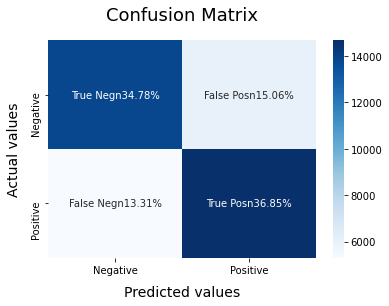

In [56]:


# =============================================================================
# NN
# =============================================================================
X=df.tweet
y=df.label

cv = CountVectorizer(max_df=0.90, min_df=2, max_features = 2500,stop_words='english')
X = cv.fit_transform(X)
# =============================================================================
# tf= TfidfVectorizer(ngram_range=(1,2), max_features=2500)
# X=tf.fit_transform(X)
# =============================================================================

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)



### Three layers of 128, 128 and 64:
from sklearn.neural_network import MLPClassifier
nnClf=MLPClassifier(hidden_layer_sizes=(128,128,64)) #three layers
nnClf.fit(X_train, y_train)
model_Evaluate(nnClf)
y_pred=nnClf.predict(X_test)
print("Three layers of 128, 128 and 64 NN accuracy score is ", accuracy_score(y_test, y_pred))
print("The confusion_matrix after prediction:\n" ,confusion_matrix(y_test,y_pred))
print("Number of mislabeled points out of a total %d points : %d\n" % (X_test.shape[0], (y_test != y_pred).sum()))
# CV result:
# Three layers of 128, 128 and 64 NN accuracy score is  0.7163414450388006
# The confusion_matrix after prediction:
# [[13851  5997]
# [ 5298 14673]]
# Number of mislabeled points out of a total 39819 points : 11295

#TF-idf result:
# Three layers of 128, 128 and 64 NN accuracy score is  0.737537356538336
#The confusion_matrix after prediction:
#[[14265  5583]
#[ 4868 15103]]
#Number of mislabeled points out of a total 39819 points : 10451

              precision    recall  f1-score   support

           0       0.71      0.72      0.72     19848
           1       0.72      0.71      0.71     19971

    accuracy                           0.72     39819
   macro avg       0.72      0.72      0.72     39819
weighted avg       0.72      0.72      0.72     39819

Four layers of 128, 128, 64 and 32 NN accuracy score is  0.7152113312740149
The confusion_matrix after prediction:
 [[14257  5591]
 [ 5749 14222]]
Number of mislabeled points out of a total 39819 points : 11340



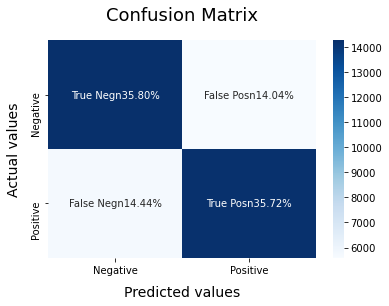

In [57]:
### Four layers of 128, 128, 64, and 32:
nnClf=MLPClassifier(hidden_layer_sizes=(128,128,64,32)) #four layers
nnClf.fit(X_train, y_train)
model_Evaluate(nnClf)
y_pred=nnClf.predict(X_test)
print("Four layers of 128, 128, 64 and 32 NN accuracy score is ", accuracy_score(y_test, y_pred))
print("The confusion_matrix after prediction:\n" ,confusion_matrix(y_test,y_pred))
print("Number of mislabeled points out of a total %d points : %d\n" % (X_test.shape[0], (y_test != y_pred).sum()))
# CV result:
# Four layers of 128, 128, 64 and 32 NN accuracy  = 0.7152113312740149.
# The confusion_matrix after prediction:
#  [[14257  5591]
# [ 5749 14222]]
# Number of mislabeled points out of a total 39819 points : 11340

#TF-idf result:
#Four layers of 128, 128, 64 and 32 NN accuracy score is  0.7394208794796454
#The confusion_matrix after prediction:
# [[14729  5119]
# [ 5257 14714]]
#Number of mislabeled points out of a total 39819 points : 10376    

In [58]:

# Now using PCA:
X=df.tweet
y=df.label

cv = CountVectorizer(max_df=0.90, min_df=2, max_features = 2500,stop_words='english')
X = cv.fit_transform(X)

# =============================================================================
# tf= TfidfVectorizer(ngram_range=(1,2), max_features=2500)
# X=tf.fit_transform(X)
# =============================================================================

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)



from sklearn.decomposition import TruncatedSVD,PCA
x=X.toarray() # or use TruncatedSVD for sparse input x
r=0.8# 2500 to 875 features with CV, to 1151 features with TF-idf
pca1=PCA(n_components=r)
X_pca=pca1.fit_transform(x) 

X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca,y,test_size=0.2,random_state=5)


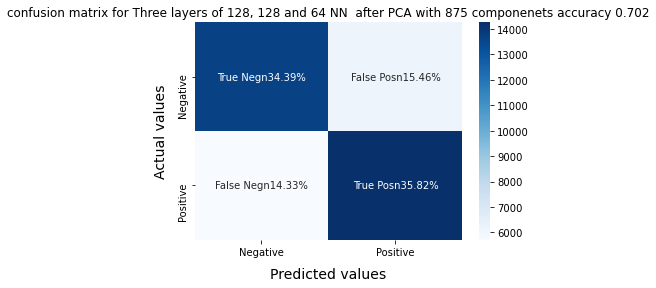

The accuracy score is = 0.7021271252417188


In [59]:
### Three layers of 128,128,64 with PCA:
nnClf_pca=MLPClassifier(hidden_layer_sizes=(128,128,64)) #three layers
nnClf_pca.fit(X_train_pca, y_train)
y_pred_pca=nnClf_pca.predict(X_test_pca)
C_pca=confusion_matrix(y_test, y_pred_pca)
categories = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in C_pca.flatten() / np.sum(C_pca)]
labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(C_pca, annot = labels, cmap = 'Blues',fmt = '',
xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title(f"confusion matrix for Three layers of 128, 128 and 64 NN  after PCA with {X_pca.shape[1]} componenets accuracy {sum(np.diag(C_pca))/C_pca.sum():5.3}")
plt.show()
acc = accuracy_score(y_pred_pca,y_test)
print(f"The accuracy score is = {acc}")


# CV Result: The accuracy score is = 0.7021271252417188
    
#TF-idf Result: The accuracy score is = 0.7233983776589066

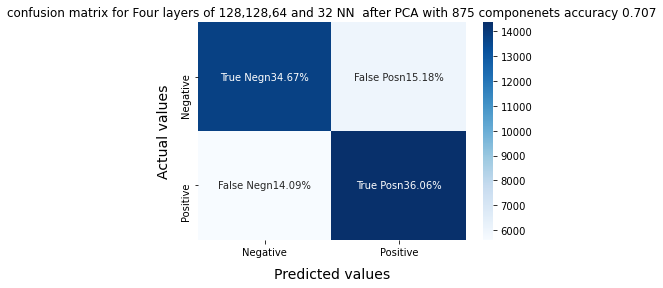

The accuracy score is = 0.7073256485597328


In [60]:
### Four layers of 128,128,64 and 32 with PCA:
nnClf_pca=MLPClassifier(hidden_layer_sizes=(128,128,64,32))
nnClf_pca.fit(X_train_pca, y_train)
y_pred_pca=nnClf_pca.predict(X_test_pca)
C_pca=confusion_matrix(y_test, y_pred_pca)
categories = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in C_pca.flatten() / np.sum(C_pca)]
labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(C_pca, annot = labels, cmap = 'Blues',fmt = '',
xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title(f"confusion matrix for Four layers of 128,128,64 and 32 NN  after PCA with {X_pca.shape[1]} componenets accuracy {sum(np.diag(C_pca))/C_pca.sum():5.3}")
plt.show()
acc = accuracy_score(y_pred_pca,y_test)
print(f"The accuracy score is = {acc}")
# CV Result: The accuracy score is = 0.7073256485597328

#TF-idf Result: The accuracy score is = 0.7259599688590874